In [ ]:
! pip install findspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.context import SparkContext
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, mean, stddev, count, when, hour
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [ ]:
# Step 1: Start Spark session
spark = SparkSession.builder.appName("NYC Taxi Data Analysis").getOrCreate()

In [ ]:
# Set legacy time parser policy to handle datetime parsing issue
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [ ]:
# Step 2: Load the dataset
data_path = "/content/drive/MyDrive/2020_Yellow_Taxi_Trip_Data.csv"
df = spark.read.option("header", "true").option("inferSchema", "true").csv(data_path)


In [ ]:
# Display schema and first 10 rows
df.printSchema()
df.show(10)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+---

In [ ]:
# Remove extreme outliers for a clearer visualization
fare_df_filtered = fare_df[fare_df['fare_amount'] < fare_df['fare_amount'].quantile(0.99)]


In [ ]:
# Apply log transformation safely using .loc[]
fare_df_filtered = fare_df_filtered[fare_df_filtered['fare_amount'] >= 0]
fare_df_filtered.loc[:, 'log_fare_amount'] = np.log1p(fare_df_filtered['fare_amount'])


Text(0.5, 1.0, 'Log-Transformed Distribution of Fare Amount')

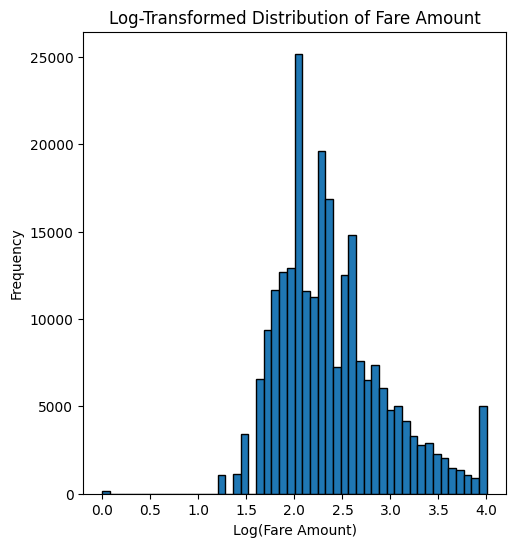

In [ ]:
# Plotting the filtered histogram
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(fare_df_filtered['log_fare_amount'], bins=50, edgecolor='k')
plt.xlabel('Log(Fare Amount)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Distribution of Fare Amount')


In [ ]:
# Count total number of rows
print(f"Total rows: {df.count()}")

Total rows: 24648499


In [ ]:
# Step 3: Data Cleaning and Transformation
# Handle missing values
df = df.fillna({'passenger_count': 1, 'trip_distance': 0.0, 'fare_amount': 0.0, 'total_amount': 0.0, 'RatecodeID': 1, 'PULocationID': 0, 'DOLocationID': 0, 'extra': 0.0, 'mta_tax': 0.0, 'tip_amount': 0.0, 'tolls_amount': 0.0, 'improvement_surcharge': 0.0, 'congestion_surcharge': 0.0})


In [ ]:
# Remove duplicates
df = df.dropDuplicates()

In [ ]:
# Convert date columns to timestamp format
df = df.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"), 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime"), 'MM/dd/yyyy hh:mm:ss a'))

In [ ]:
# Filter out invalid rows
df = df.filter((col("fare_amount") > 0) & (col("trip_distance") > 0) & (col("total_amount") > 0))


In [ ]:
# Step 4: Data Analysis Using Spark SQL
# Register DataFrame as a temporary view
df.createOrReplaceTempView("taxi_data")

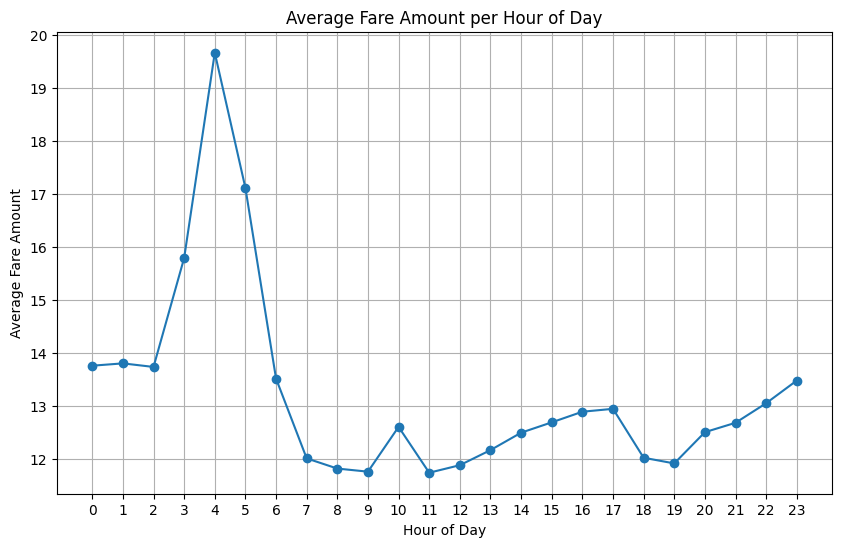

In [ ]:
# Time-Based Analysis: Average Fare Per Hour
from pyspark.sql.functions import hour, avg

# Extract hour from pickup datetime and calculate average fare per hour
df_with_hour = df.withColumn('hour', hour('tpep_pickup_datetime'))
avg_fare_per_hour = df_with_hour.groupBy('hour').agg(avg('fare_amount').alias('avg_fare')).orderBy('hour')

# Convert to Pandas for visualization
avg_fare_per_hour_pd = avg_fare_per_hour.toPandas()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(avg_fare_per_hour_pd['hour'], avg_fare_per_hour_pd['avg_fare'], marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount')
plt.title('Average Fare Amount per Hour of Day')
plt.xticks(range(0, 24))
plt.grid()
plt.show()


In [ ]:
# Aggregation: Summary statistics
summary_stats = spark.sql("SELECT mean(trip_distance) as mean_distance, stddev(trip_distance) as stddev_distance, mean(fare_amount) as mean_fare, stddev(fare_amount) as stddev_fare FROM taxi_data")
summary_stats.show()

+----------------+-----------------+-----------------+------------------+
|   mean_distance|  stddev_distance|        mean_fare|       stddev_fare|
+----------------+-----------------+-----------------+------------------+
|3.57780316551149|327.8868366627186|12.56590485997691|249.55441573195571|
+----------------+-----------------+-----------------+------------------+



In [ ]:
# Grouping and Filtering: Payment type aggregation
payment_type_stats = spark.sql("SELECT payment_type, COUNT(*) as count, mean(fare_amount) as avg_fare, mean(tip_amount) as avg_tip FROM taxi_data GROUP BY payment_type")
payment_type_stats.show()


+------------+--------+------------------+--------------------+
|payment_type|   count|          avg_fare|             avg_tip|
+------------+--------+------------------+--------------------+
|        NULL|  782132|28.457660688986646|  1.7902185692440715|
|           1|17255110|12.022605439779861|   2.856210246705015|
|           3|   95114|27.207448009756714|0.002754694366759888|
|           4|   34161|33.537048973976184|0.003125201252890...|
|           2| 6049714| 11.71233878328793|1.757785574656917...|
|           5|      13|17.192307692307693|                 0.0|
+------------+--------+------------------+--------------------+



In [ ]:
# Time-based analysis: Average fare over pickup hour
fare_over_time = spark.sql("SELECT hour(tpep_pickup_datetime) as pickup_hour, mean(fare_amount) as avg_fare, mean(tip_amount) as avg_tip FROM taxi_data GROUP BY pickup_hour ORDER BY pickup_hour")
fare_over_time.show()

+-----------+------------------+------------------+
|pickup_hour|          avg_fare|           avg_tip|
+-----------+------------------+------------------+
|          0|13.754564663210669| 2.214842360196279|
|          1|13.798309707093399|1.9957100403486778|
|          2|13.731122822260732|1.8455016463728984|
|          3| 15.78528580078217|1.7867410692369317|
|          4|19.656949448672123| 1.832577328260079|
|          5|17.105977080295688|  2.21698043127926|
|          6| 13.51073987733805|1.9138990835952499|
|          7| 12.00650741117259|1.9677738457768381|
|          8|11.814674316698936|2.0412325514500274|
|          9| 11.75609403803701|2.0058454142928874|
|         10|12.600684940579667|1.9594897880754314|
|         11| 11.73617026664828| 1.931448334150607|
|         12|11.878242228852212|1.9482519452178662|
|         13|12.162659636890384|1.9739613034413683|
|         14|12.491189499790902|2.0203585106767834|
|         15|12.686073017699123|2.0500368002804246|
|         16

In [ ]:
# Step 5: Machine Learning Model - Regression to predict fare amount
# Select features and label
feature_cols = ["trip_distance", "passenger_count", "RatecodeID", "PULocationID", "DOLocationID", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [ ]:
# Normalize features
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [ ]:
# Initialize Linear Regression model
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="fare_amount")

In [ ]:
# Build pipeline
pipeline = Pipeline(stages=[assembler, scaler, lr])

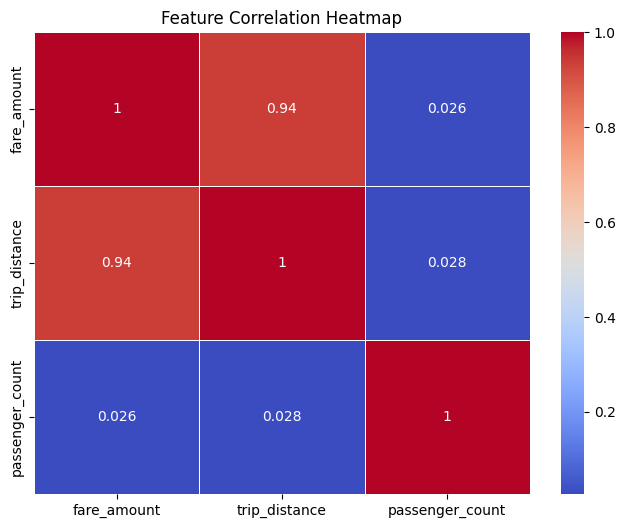

In [ ]:
import seaborn as sns

# Select numerical features for correlation and limit to a manageable size
numeric_features = ['fare_amount', 'trip_distance', 'passenger_count']
numeric_df = df.select(numeric_features).dropna().limit(10000).toPandas()

# Plotting the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


In [ ]:
# Split data into training and test sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Ensure the train_df and test_df are cached to avoid re-computation
train_df = train_df.cache()
test_df = test_df.cache()

In [ ]:
# Model training
model = pipeline.fit(train_df)

In [ ]:
# Evaluate initial model on test data
initial_test_results = model.transform(test_df)
initial_rmse = evaluator.evaluate(initial_test_results)
print(f"Initial Root Mean Squared Error (RMSE) on test data before tuning = {initial_rmse}")


Initial Root Mean Squared Error (RMSE) on test data before tuning = 8.24487009498827


In [ ]:
# Step 6: Model Tuning and Evaluation
# Hyperparameter tuning with CrossValidator
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(labelCol="fare_amount", metricName="rmse"),
                          numFolds=3)

In [ ]:
# Train model
cv_model = crossval.fit(train_df)

In [ ]:
# Evaluate model on test data
test_results = cv_model.transform(test_df)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(test_results)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

Root Mean Squared Error (RMSE) on test data = 8.211649042725572
